# Marcer-Marchisciana
**Andrea Marcer - 10537040**

**Matteo Marchisciana - 10586574**

For this homework we decided to approach the problem with a model that has 2 inputs: one for the image and one for the question.

## Encoding the question
To encode the question we followed the approach showed during classes. We removed from the question common words that gave no additional meaning to the question itself like "the", the apostrophe and words that are removed by default by the Tokenizer function in Keras.

We then created a Tokenizer and fit it to the questions, then used *texts_to_matrix* to create a bag of words-like encoding (can be seen as an OR between one-hot vectors).

We then created a CustomDataset object that, using these matrixes, is able to return a training batch composed of the encoded question and the corresponding image.

## Image preprocessing
We felt that there was no need to preprocess images, because they are very simple. When using transfer learning methods, such as the Xception model, we used the same preprocessing function used to train the model.

## General approach
The general approach we used was to combine a convolutional neural network to extract meaningful patterns from the image with an encoder of the question, then feed these information to a fully connected network to succesfully answer the question.
We tried different approaches regarding the CNN, the question encoder and the way to merge information coming from these two networks. 

## CNN
For CNNs we tried using transfer learning and leverage the power of the already trained Xception and VGG models to extract patterns from the image.

## Question encoder
For the question encoder we used a fully connected layer after the input. Since we were dealing with a bag of words-like encoding, that is a sparse representation of the question, we tried to project it in a lower dimensional vector (128/256 from 5000+ neurons).

## Merging
This is where we spent more time designing and testing various approaches, looking for the best one. The approaches we tried were:

* **GAP**: used to reduce the dimension of the image feature vector in output from the CNN;
* **Concat**: the first attempt was to simply concatenate the word encoding vector with the one produced by the CNN and then feed it directly to the fully connected network to predict the answer;
* **Multiply**: we tried different activation functions (softmax, sigmoid, tanh) for the output of the question encoder and then multiply it with the feature vector of the image. The aim was to produce an attention-like mechanism with the purpose of enhancing those features that were relevant for the question;
* **Attention**: in the end we tried to implement, first by ourselves then by using the already built-in keras layer, the attention mechanism. We thought that by using the question to extract an attention vector the network would have been able to focus on relevant image features. Unfortunately the addition of this mechanism didn't improve the network accuracy. 

## Autoencoder
We looked at the distribution of answers in the training set and we saw that it was very unbalanced, with an high percentage of answers being "yes", "no" and "2". For this reason we tried to exploit this unbalance and trained a network that uses only the question to predict the answer. Our purpose was that we could combine this model with the approaches listed above to "steer" the model into giving the right answer and increase its accuracy.
We saw that the model reached an accuracy of 60% on the validation set. Given its high performance relative to the simplicity of the model, we tested this on the test set and achieved the same accuracy. This was not surprising given that the sum of the three most popular answers made up close to that percentage of the training set.

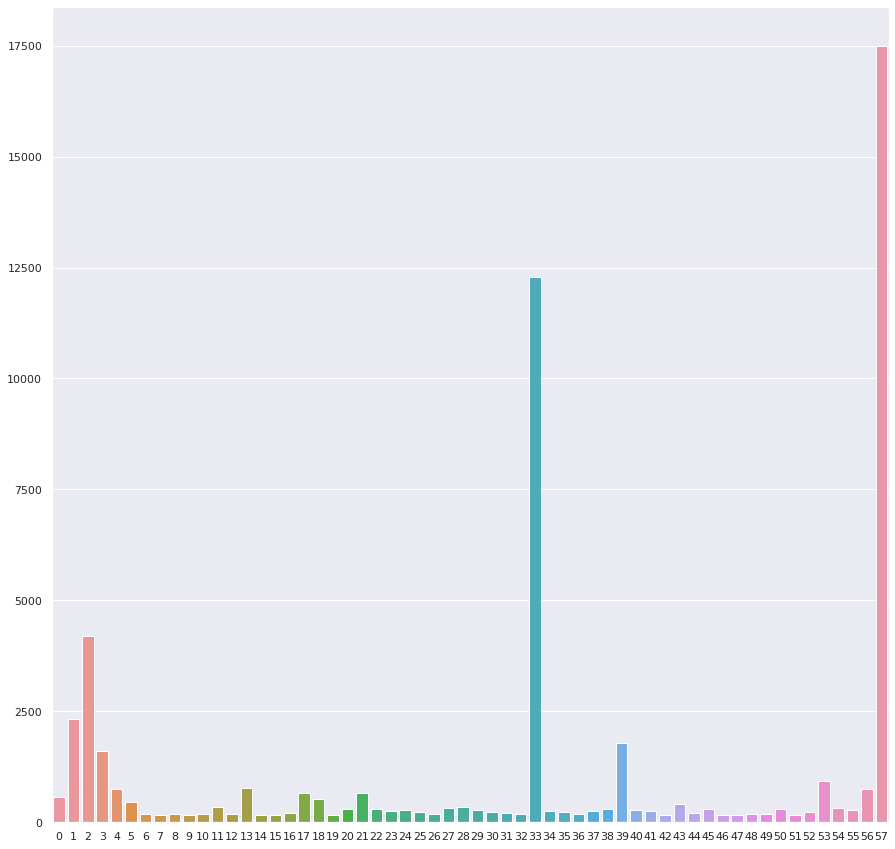

## Final considerations
All the different approaches and techniques we tried were unable to surpass ~62% accuracy on the validation set. We had some hypotesis regarding why this happened.
First, we thought that already trained models, like VGG and Xception, were trained on images taken from real life and not simplified ones like the training set. However, we also tried to train difrent models from scratch and the accuracy did not improve.
Second, we thought that the encoding of the question was too sparse to give useful information to the model. This is the reason why we tried to project it into a lower dimensional network. 
Lastly, and likely the leading cause, was that our approach of combining information coming from the CNN network with the one coming from the encoding network was inadequate. As a potentian proof of this, we saw that the performance obtained with CNN + encoding approaches was only slightly better than the autoencoder approach, which receives no image in input.



# Initialization

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random as rand
import json
import gc
import seaborn as sns

from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l1, l2, l1_l2
from PIL import Image, ImageOps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cwd = '/content/drive/MyDrive/Homework3'
SEED = 59639701

################################################################################
dataset_path = os.path.join(cwd, 'VQA_Dataset')
train_path = os.path.join(dataset_path, 'Images')

tf.random.set_seed(SEED)
np.random.seed(SEED)
rand.seed(SEED)

# Dataset

In [ ]:
def removeFrequentWords(sentence):
  string = str.lower(sentence)
  string = string.replace("\'s", "")
  string = string.replace("\'", "")
  string = string.replace(" the ", " ")
  return string

## Train

In [ ]:
train_json_path = os.path.join(dataset_path, 'train_questions_annotations.json')

train_data = {'question':[], 'answer':[], 'image_id':[], 'one_hot_question': [], 'id':[]}

with open(train_json_path, 'r') as f:
  data_train = json.load(f)
f.close()

for item in data_train:
  element = data_train[item]

  question = removeFrequentWords(element['question'])
  answer = element['answer']
  filename = element['image_id']

  train_data['id'].append(item)
  train_data['question'].append(question)
  train_data['answer'].append(answer)
  train_data['image_id'].append(filename)

## Test

In [ ]:
test_json_path = os.path.join(dataset_path, 'test_questions.json')

test_data = {'question':[], 'image_id':[], 'one_hot_question': [], 'id':[]}

with open(test_json_path, 'r') as f:
  data_test = json.load(f)
f.close()

for item in data_test:
  element = data_test[item]

  question = removeFrequentWords(element['question'])
  filename = element['image_id']

  test_data['id'].append(item)
  test_data['question'].append(question)
  test_data['image_id'].append(filename)

## Complete

In [ ]:
question_tokenizer = Tokenizer()
question_tokenizer.fit_on_texts(train_data['question'])

train_one_hot_encoding = question_tokenizer.texts_to_matrix(train_data['question'])
for quest in train_one_hot_encoding:
   train_data['one_hot_question'].append(quest)

test_one_hot_encoding = question_tokenizer.texts_to_matrix(test_data['question'])
for quest in test_one_hot_encoding:
   test_data['one_hot_question'].append(quest)

num_words = len(question_tokenizer.index_word) + 1
num_train_quesitons = len(train_data['question'])
num_test_quesitons = len(test_data['question'])

print("Number of words: ", num_words)
print("Number of train questions: ", num_train_quesitons)
print("Number of test questions: ", num_test_quesitons)

Number of words:  4527
Number of train questions:  58832
Number of test questions:  6372


In [ ]:
del data_test
del data_train
del question_tokenizer
del train_one_hot_encoding
del test_one_hot_encoding

gc.collect()

0

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


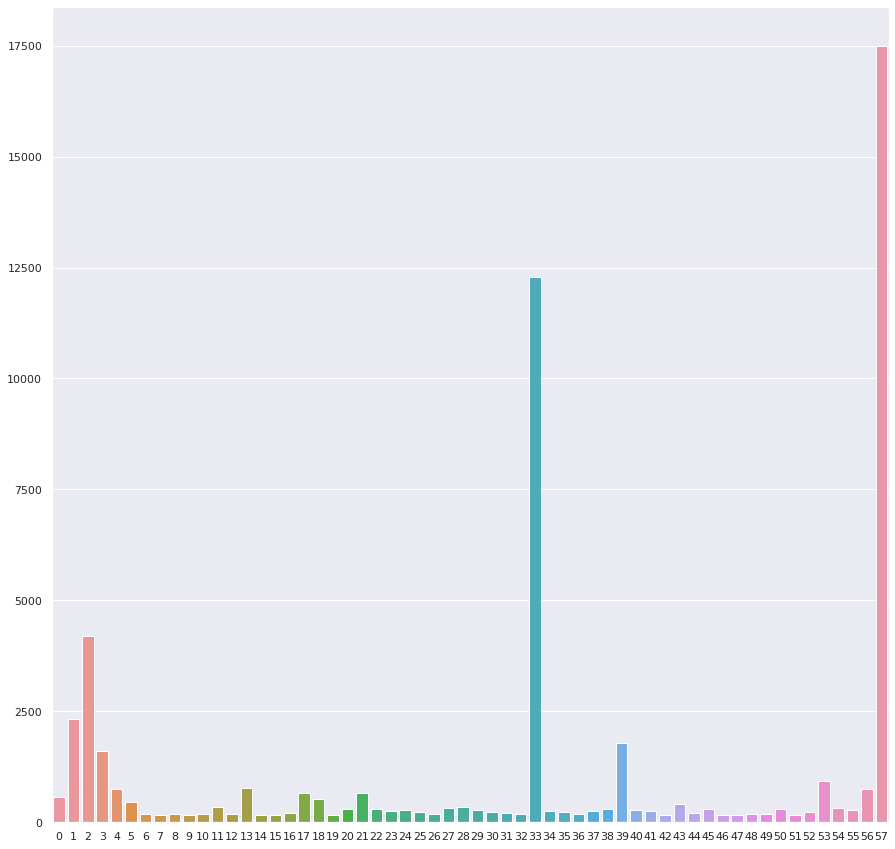

In [ ]:
# Answer dataset distribution
sns.set(rc={'figure.figsize':(15,15)})
counting = []

for i in range(0,58):
  counting.append(0);

for ans in training_data['answer']:
  counting[labels_dict[ans]] += 1

sns.barplot(np.arange(58), counting)

## Dataset

In [ ]:
################################################################################
img_h = 400
img_w = 700
channels = 3

input_dim = 256

batch_size = 32

################################################################################
labels_dict = {'0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [ ]:
validation_split = 0.05
datase_dim = len(train_data['answer'])

train_data_shuffled={'answer':[], 'one_hot_question':[], 'image_id':[]}

train_data_zipped = list(zip(train_data['answer'][0:datase_dim], train_data['one_hot_question'][0:datase_dim], train_data['image_id'][0:datase_dim]))
rand.shuffle(train_data_zipped)
train_data_shuffled['answer'], train_data_shuffled['one_hot_question'], train_data_shuffled['image_id']= zip(*train_data_zipped)

print(len(train_data_shuffled['one_hot_question'][0:datase_dim]))

training_data = {'answer':train_data_shuffled['answer'][0:int(datase_dim*(1-validation_split))],
              'one_hot_question': train_data_shuffled['one_hot_question'][0:int(datase_dim*(1-validation_split))],
              'image_id':train_data_shuffled['image_id'][0:int(datase_dim*(1-validation_split))]}
validation_data = {'answer':train_data_shuffled['answer'][-int(datase_dim*validation_split):],
              'one_hot_question': train_data_shuffled['one_hot_question'][-int(datase_dim*validation_split):],
              'image_id': train_data_shuffled['image_id'][-int(datase_dim*validation_split):]}

print('training: ', len(training_data['answer']))
print('validation: ', len(validation_data['answer']))

58832
training:  55890
validation:  2941


In [ ]:
def preprocess_image(image, shape):
  img = image.resize(shape, Image.BICUBIC)
  img = np.array(img, dtype = np.float32)[:, :, 0:3] / 255.0
  return img

def get_answer(target):
  return label_dict['answer'][argmax(target)]

class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self, shape=(input_dim, input_dim), n_channels=channels, shuffle=True, which_subset='train'):
    self.shape = shape
    self.which_subset = which_subset
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    if(self.which_subset == 'train'):
      return int(np.floor(len(training_data['answer']) / batch_size))
    else:
      return int(np.floor(len(validation_data['answer']) / batch_size))

  def on_epoch_end(self):
    if(self.which_subset == 'train'):
      self.indexes = np.arange(len(training_data['answer']))
      if self.shuffle == True:
        np.random.shuffle(self.indexes)
    else:
      self.indexes = np.arange(len(validation_data['answer']))

  def __getitem__(self, index):
    indexes = self.indexes[index*batch_size:(index+1)*batch_size]

    X_img = []
    X_question = []
    Y = []
    W = [] #Since answers have very different frequences we devided to weight samples which label is 'yes' or 'no' less

    if(self.which_subset == 'train'):
      for i in indexes:
        filename = os.path.join(train_path, training_data['image_id'][i] + str(".png"))
        #print("opening: ", filename)
        img = Image.open(filename)
        img = preprocess_image(img, self.shape)

        #print(i, " -> ", train_data['id'][i], train_data['image_id'][i], img.shape, train_data['question'][i])

        target = np.zeros(len(labels_dict), dtype=np.float32)
        answer_position = labels_dict[training_data['answer'][i]]
        target[answer_position] = 1

        X_img.append(img)
        X_question.append(training_data['one_hot_question'][i])
        Y.append(target)
        W.append(1 if answer_position != 33 and answer_position != 57 else 0.3)
    else:
      for i in indexes:
        filename = os.path.join(train_path, validation_data['image_id'][i] + str(".png"))
        img = preprocess_image(Image.open(filename), self.shape)

        target = np.zeros(len(labels_dict), dtype=np.float32)
        target[labels_dict[validation_data['answer'][i]]] = 1

        X_img.append(img)
        X_question.append(validation_data['one_hot_question'][i])
        Y.append(target)
        W.append(1)

    X = [np.array(X_img, dtype=np.float32), np.array(X_question, dtype=np.float32)]
    return X, np.array(Y, dtype=np.float32), np.array(W)

In [ ]:
# defint custom data generators
train_data_gen = CustomDataset(which_subset='train')
validation_data_gen = CustomDataset(which_subset='valid')
print("Train dataset dimension: ", len(train_data_gen))
print("Valid dataset dimension: ", len(validation_data_gen))

Train dataset dimension:  1746
Valid dataset dimension:  91


In [ ]:
for j in range(len(validation_data_gen)):
  x, y, z = validation_data_gen.__getitem__(j)
  for i in range(batch_size):
    print("Question: ", x[1][i])
    print("Answer: ", y[i])
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow((x[0][i]))
    plt.show()

# Encoder Dataset

In [ ]:
################################################################################
word_encoder_input_dim = num_words

word_encoder_batch_size = 256

################################################################################
labels_dict = {'0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [ ]:
validation_split = 0.1
datase_dim = num_train_quesitons

train_data_shuffled={'answer':[], 'one_hot_question':[]}

train_data_zipped = list(zip(train_data['answer'][0:datase_dim], train_data['one_hot_question'][0:datase_dim]))
rand.shuffle(train_data_zipped)
train_data_shuffled['answer'], train_data_shuffled['one_hot_question'] = zip(*train_data_zipped)

print(len(train_data_shuffled['one_hot_question'][0:datase_dim]))

word_train_data = {'answer':train_data_shuffled['answer'][0:int(datase_dim*(1-validation_split))],'one_hot_question': train_data_shuffled['one_hot_question'][0:int(datase_dim*(1-validation_split))]}
word_valid_data = {'answer':train_data_shuffled['answer'][-int(datase_dim*validation_split):],'one_hot_question': train_data_shuffled['one_hot_question'][-int(datase_dim*validation_split):]}

def get_answer(target):
  return label_dict['answer'][argmax(target)]

class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self, shape=word_encoder_input_dim, shuffle=True, which_subset=None):
    self.shape = shape
    self.which_subset = which_subset
    
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    if self.which_subset == 'training':
      return int(np.floor(len(word_train_data['one_hot_question']) / word_encoder_batch_size))
    else:
      return int(np.floor(len(word_valid_data['one_hot_question']) / word_encoder_batch_size))

  def on_epoch_end(self):
    if self.which_subset == 'training':
      self.indexes = np.arange(len(word_train_data['one_hot_question']))
      if self.shuffle == True:
        np.random.shuffle(self.indexes)
    else:
      self.indexes = np.arange(len(word_valid_data['one_hot_question']))

  def __getitem__(self, index):
    indexes = self.indexes[index*word_encoder_batch_size:(index+1)*word_encoder_batch_size]

    X_question = []
    Y = []

    for i in indexes:
      answer = np.zeros(len(labels_dict), dtype=np.float32)

      if self.which_subset == 'training':
        question_encoded = word_train_data['one_hot_question'][i]
        answer[labels_dict[word_train_data['answer'][i]]] = 1
      else:
        question_encoded = word_valid_data['one_hot_question'][i]
        answer[labels_dict[word_valid_data['answer'][i]]] = 1

      X_question.append(question_encoded)
      target = question_encoded.copy()
      Y.append(concatenate((target,answer)))    
    return np.array(X_question), np.array(Y, dtype=np.float32)

58832


In [ ]:
# defint custom data generators
train_word_encoder_data_gen = CustomDataset(which_subset='training')
valid_word_encoder_data_gen = CustomDataset(which_subset='validation')
print("Train dataset dimension: ", len(train_word_encoder_data_gen))
print("Valid dataset dimension: ", len(valid_word_encoder_data_gen))

Train dataset dimension:  206
Valid dataset dimension:  22


In [ ]:
def word_encoding_model(hidden_dim = 256, lambda_reg = 0.1):
  word_input = tf.keras.Input(shape = [num_words])
  dense = Dense(
      hidden_dim, 
      activation="elu", 
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      kernel_regularizer=l2(lambda_reg),
      bias_regularizer=l2(lambda_reg),
      use_bias = True
      )(word_input)
  output = Dense(
      len(labels_dict) + num_words, 
      activation="sigmoid",
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      kernel_regularizer=l2(lambda_reg),
      bias_regularizer=l2(lambda_reg),
      use_bias = True
      )(dense)
  return Model(word_input, output)

In [ ]:
##########################################################################
# where to save model in model checkpoint
model_name = 'encoder_v1'

early = True
checkpoint = True

#Loss
loss = tf.keras.losses.MeanSquaredError()

# learning rate
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=1e-2,
#     momentum=0.0, 
#     nesterov=False
# )

def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/word_encoder_batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/word_encoder_batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/word_encoder_batch_size

# Validation metrics
metrics = ['accuracy', distance, distance_t, distance_p]

# Epochs
epochs = 1000
##########################################################################

filepath = os.path.join(cwd, model_name)

callback_list = []

# Early stopping
if(early):
  es = EarlyStopping(
    monitor = 'val_distance',
    min_delta = 0, 
    patience = 40,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True)
  callback_list.append(es)

# Model Checkpoint
if(checkpoint):
  cp = ModelCheckpoint(
    filepath=os.path.join(cwd, model_name),
    monitor='val_distance',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq="epoch")
  callback_list.append(cp)

In [ ]:
model = word_encoding_model(128, 1e-7)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(
    train_word_encoder_data_gen,
    epochs = epochs,
    steps_per_epoch = train_word_encoder_data_gen.__len__(),
    callbacks = callback_list,
    validation_data = valid_word_encoder_data_gen,
    validation_steps = valid_word_encoder_data_gen.__len__()
  )

In [ ]:
hidden_dims = [128]
lambdas_ = [1e-9]
for hidden_dim in hidden_dims:
  for lambda_ in lambdas_:
    print("######################################################", hidden_dim, lambda_, "###########################################")
    #model = word_encoding_model(hidden_dim, lambda_)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    hist = model.fit(
      train_word_encoder_data_gen,
      epochs = epochs,
      steps_per_epoch = train_word_encoder_data_gen.__len__(),
      callbacks = callback_list,
      validation_data = valid_word_encoder_data_gen,
      validation_steps = valid_word_encoder_data_gen.__len__(),
      # use_multiprocessing = True,
      # workers = 5
    )
    print("############################################################################################################")
    

In [ ]:
def predict(X):
  prediction = model.predict(X)

  question = prediction[0][0:num_words]
  answers = prediction[0][-len(labels_dict):]
  answer = np.argmax(answers)

  answer_text = []

  for i in range(5):
    for key in labels_dict.keys():
      if(labels_dict[key] == answer):
        answer_text.append(key + ': ' + str(answers[answer]))

    answers[answer] = 0
    answer = np.argmax(answers)

  question = [1 if a_ > 0.02 else 0 for a_ in question]
  question_text = []
  for i in range(0,num_words):
    if (question[i] == 1):
      question_text.append(question_tokenizer.index_word[i])

  return question_text, answer_text

In [ ]:
for i in range(5000,5015):
  print("\n",test_data['question'][i])
  pred_question, pred_answ = predict(np.expand_dims(test_data['one_hot_question'][i], 0))
  img = Image.open(os.path.join(dataset_path, 'Images', str(test_data['image_id'][i]) + '.png'))
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(img)
  plt.show()
  print(pred_answ)
  print(pred_question)
  print("#######################################################################")

# Models


## Dumb model (concatenation)

In [ ]:
##################################################
# depth = 5
# filters=64
##################################################

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  x = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization(
    center=True,
    scale=True,
    fused=True)(x)
  x = tf.keras.activations.elu(x)

  x = Flatten(name='flatten')(x)

  x = Dense(output_dim, activation="elu")(x)

  return x

In [ ]:
def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim, activation="elu")(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 32
image_output_dim = 512

# question encoder
question_output_dim = 512

# hidden layers
number_hidden = 2
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = image_output_dim)

question_encoder_ouput = model_sentence_encoder_create(question_input, output_dim = question_output_dim)

x = concatenate([image_encoder_ouput, question_encoder_ouput])

for i in range(number_hidden):
  x = Dense(hidden_dimension, activation="elu")(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

## Model Attention

In [ ]:
##################################################
# depth = 5
# filters=64
##################################################

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  x = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  x = tf.keras.activations.elu(x)

  x = Flatten(name='flatten')(x)

  x = Dense(output_dim, activation="elu")(x)

  return x

In [ ]:
def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim, activation="softmax")(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
freeze_until = 30

output_dim = 512

# hidden layers
number_hidden = 2
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim)

question_encoder_ouput = model_sentence_encoder_create(question_input, output_dim = output_dim)

x = Multiply()([image_encoder_ouput, question_encoder_ouput])

for i in range(number_hidden):
  x = Dense(hidden_dimension, activation="elu")(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[512, 512, 3])
#vgg.summary()

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[29].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

## Xception

In [ ]:
## The top of xception is a global average pooling with output 2048 and then a dense with output 1000 and i guess a softmax.
## This is because the last layer before the top is a None, 10, 10, 2048

xception = tf.keras.applications.Xception(include_top=False,
                                          weights="imagenet",
                                          input_shape=(299,299,3))
xception.trainable = False

input = tf.keras.layers.Input([299, 299, 3], dtype=tf.float32)
preprocess = tf.keras.applications.xception.preprocess_input(input)
xception = xception(preprocess)
xception = tf.keras.layers.GlobalAveragePooling2D()(xception)
#xception = tf.keras.layers.BatchNormalization()(xception)

question_input = tf.keras.Input(shape = [num_words])
question_dense = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling())(question_input)


#conc = tf.keras.layers.Attention()([xception, question_dense])
conc = concatenate((xception, question_dense))
#conc = Multiply()([xception, question_dense])

#conc = tf.keras.layers.BatchNormalization()(conc)

dense = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.VarianceScaling())(conc)

#dense = tf.keras.layers.BatchNormalization()(dense)

output = tf.keras.layers.Dense(len(labels_dict), activation="softmax")(dense)

model = tf.keras.Model(inputs=[input, question_input], outputs=[output])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_3 (TFOpLambda)  (None, 299, 299, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
tf.math.subtract_3 (TFOpLambda) (None, 299, 299, 3)  0           tf.math.truediv_3[0][0]          
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4527)]       0                                            
____________________________________________________________________________________________

## Model GAP + encoder + vgg

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      if (i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  # x = Conv2D(
  #   filters=filters,
  #   kernel_size=(3,3),
  #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
  #   padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  # x = tf.keras.activations.elu(x)

  x = GlobalAveragePooling2D()(x)

  x = Dense(output_dim)(x)
  x = tf.keras.activations.elu(x)

  return x

def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim)(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 5
filter_dim = 64
freeze_until = 24

output_dim = 256

# hidden layers
number_hidden = 1
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim)

question_attention_ouput = model_sentence_encoder_create(question_input, output_dim = output_dim)

question_encoder_ouput = model_sentence_encoder_create(question_input, output_dim = output_dim)

attention_question_input = tf.keras.activations.tanh(question_attention_ouput)

attention = Multiply()([image_encoder_ouput,attention_question_input])

attention = tf.keras.activations.softmax(attention)

attention = Multiply()([image_encoder_ouput,attention])

x = Concatenate()([tf.keras.activations.elu(attention),  tf.keras.activations.elu(question_encoder_ouput)])
for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",)(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[512, 512, 3])
#vgg.summary()

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[29].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

11234

## Model GAP + Attention + vgg


In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  x = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  x = tf.keras.activations.elu(x)

  x = GlobalAveragePooling2D()(x)

  return x

def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim, activation="softmax")(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
freeze_until = 24

output_dim = 512

# hidden layers
number_hidden = 2
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim)

question_encoder_ouput = model_sentence_encoder_create(question_input, output_dim = output_dim)

attention_image = Attention()([question_encoder_ouput, image_encoder_ouput])

x = Concatenate()([attention_image, question_encoder_ouput])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",)(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[512, 512, 3])
#vgg.summary()

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[29].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

58892288/58889256 [==============================] - 1s 0us/step


8951

## Model GAP + Attention 

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 64):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  x = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  x = tf.keras.activations.elu(x)

  x = GlobalAveragePooling2D()(x)

  return x

def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim)(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
max_filter_dim = 128

#encoder
model_name = 'encoder_v1'
freeze = True

output_dim = 128

# hidden layers
number_hidden = 2
hidden_dimension = 256
#####################################################################

encoder = tf.keras.models.load_model(os.path.join(cwd,model_name), custom_objects={'distance':distance,'distance_t':distance_t,'distance_p':distance_p})

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)

question_encoder_ouput = model_sentence_encoder_create(question_input, output_dim = output_dim)

attention_question_input = tf.keras.activations.tanh(question_encoder_ouput)

attention = Multiply()([image_encoder_ouput,attention_question_input])

x = Concatenate()([tf.keras.activations.elu(attention),  attention_question_input])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",)(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

model.layers[43].set_weights(encoder.layers[1].get_weights())
model.layers[43].trainable = not freeze

del encoder
gc.collect()

34647

## Model Attention + flatten

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      # if(filters > 64):
      #   x = Conv2D(
      #   filters=filters,
      #   kernel_size=(3,3),
      #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
      #   padding = 'same')(x)
      #   x = tf.keras.layers.BatchNormalization(
      #     center=True,
      #     scale=True,
      #     fused=True)(x)
      #   x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  # x = Conv2D(
  #   filters=filters,
  #   kernel_size=(3,3),
  #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
  #   padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  # x = tf.keras.activations.elu(x)
  
  return x

def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim)(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
max_filter_dim = 512

#encoder
dense_output = 64

output_dim = 512

# hidden layers
lambda_dense = 0.01
number_hidden = 2
hidden_dimension = 512
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)

encoder_attention_output = model_sentence_encoder_create(question_input, output_dim = output_dim)

encoder_dense_output = model_sentence_encoder_create(question_input, output_dim = dense_output)

attention_question_input = tf.keras.activations.tanh(encoder_attention_output)

x = Multiply()([attention_question_input, image_encoder_ouput])

x = Flatten()(x)

x = Dense(512)(x)

x = tf.keras.activations.elu(x)

x = Concatenate()([x,  tf.keras.activations.elu(encoder_dense_output)])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

gc.collect()

18653

## Model GAP + Attention + regularization
 + vgg

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  # x = Conv2D(
  #   filters=filters,
  #   kernel_size=(3,3),
  #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
  #   padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  # x = tf.keras.activations.elu(x)

  
  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.5)(x)
  
  return x

def model_sentence_encoder_create(input, output_dim=512, lambda_ref = 0.000001):
  x = question_input
  x = Dense(output_dim,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    kernel_regularizer=l2(lambda_ref), 
    bias_regularizer=l2(lambda_ref))(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 5
filter_dim = 64
max_filter_dim = 512
freeze_until = 28

output_dim = 512

# hidden layers
lambda_dense = 0.001
number_hidden = 2
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)

encoder_attention_output = tf.keras.activations.elu(model_sentence_encoder_create(question_input, output_dim = 128, lambda_ref = 1e-6))
encoder_attention_output = Dense(
    output_dim,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    kernel_regularizer=l2(1e-6), 
    bias_regularizer=l2(1e-6))(encoder_attention_output)

#encoder_dense_output = tf.keras.activations.softmax(model_sentence_encoder_create(question_input, output_dim = dense_output, lambda_ref = 1e-6))

attention_question_input = tf.keras.activations.softmax(encoder_attention_output)

#x = Multiply()([attention_question_input, image_encoder_ouput])

x = Multiply()([image_encoder_ouput, attention_question_input])

# x = Concatenate()([x,  encoder_dense_output])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    activation="elu",
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[256, 256, 3])

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[30].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

58892288/58889256 [==============================] - 0s 0us/step


1738

## Model GAP + Attention + regularization

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(
        center=True,
        scale=True,
        fused=True)(x)
      x = tf.keras.activations.elu(x)

      # if(filters > 64):
      #   x = Conv2D(
      #   filters=filters,
      #   kernel_size=(3,3),
      #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
      #   padding = 'same')(x)
      #   x = tf.keras.layers.BatchNormalization(
      #     center=True,
      #     scale=True,
      #     fused=True)(x)
      #   x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  # x = Conv2D(
  #   filters=filters,
  #   kernel_size=(3,3),
  #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
  #   padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  # x = tf.keras.activations.elu(x)

  
  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.5)(x)
  
  return x

def model_sentence_encoder_create(input, output_dim=512, lambda_ref = 0.000001):
  x = question_input
  x = Dense(output_dim,
    kernel_regularizer=l2(lambda_ref), 
    bias_regularizer=l2(lambda_ref))(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
max_filter_dim = 256

#encoder
dense_output = 256

output_dim = 256

# hidden layers
lambda_dense = 0.001
number_hidden = 2
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)

encoder_attention_output = model_sentence_encoder_create(question_input, output_dim = output_dim, lambda_ref = 1e-6)

#encoder_dense_output = tf.keras.activations.softmax(model_sentence_encoder_create(question_input, output_dim = dense_output, lambda_ref = 1e-6))

attention_question_input = tf.keras.activations.softmax(encoder_attention_output)

#x = Multiply()([attention_question_input, image_encoder_ouput])

x = Multiply()([image_encoder_ouput, attention_question_input])

# x = Concatenate()([x,  encoder_dense_output])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

gc.collect()

109

## Model GAP + Attention + vgg


In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  # x = Conv2D(
  #   filters=filters,
  #   kernel_size=(3,3),
  #   kernel_initializer=tf.keras.initializers.VarianceScaling(),
  #   padding = 'same')(x)
  # x = tf.keras.layers.BatchNormalization(
  #   center=True,
  #   scale=True,
  #   fused=True)(x)
  # x = tf.keras.activations.elu(x)

  x = GlobalAveragePooling2D()(x)

  return x

def model_sentence_encoder_create(input, output_dim=512):
  x = question_input
  x = Dense(output_dim)(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 6
filter_dim = 64
freeze_until = 24
max_filter_dim = 512

#encoder
dense_output = 128

output_dim = 512

# hidden layers
lambda_dense = 0.01
number_hidden = 2
hidden_dimension = 512
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)

encoder_attention_output = model_sentence_encoder_create(question_input, output_dim = output_dim)

encoder_dense_output = tf.keras.activations.elu(model_sentence_encoder_create(question_input, output_dim = dense_output))

attention_question_input = tf.keras.activations.sigmoid(encoder_attention_output)

image_encoder_ouput = Dropout(0.5)(image_encoder_ouput)

x = Multiply()([attention_question_input, image_encoder_ouput])

x = Concatenate()([x,  encoder_dense_output])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    activation="elu",
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[512, 512, 3])
#vgg.summary()

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[29].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

21646

## Model GAP + Attention luong + regularization + vgg

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size

def distance_t(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true))/batch_size

def distance_p(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_pred))/batch_size

def model_image_encoder_create(input, depth=5, filters=64, output_dim=512, max_filter_dim = 512):
  x = input

  for i in range (0,depth):
      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
      # x = tf.keras.layers.BatchNormalization(
      #   center=True,
      #   scale=True,
      #   fused=True)(x)
      x = tf.keras.activations.elu(x)

      if(filters > 128):
        x = Conv2D(
        filters=filters,
        kernel_size=(3,3),
        kernel_initializer=tf.keras.initializers.VarianceScaling(),
        padding = 'same')(x)
        # x = tf.keras.layers.BatchNormalization(
        #   center=True,
        #   scale=True,
        #   fused=True)(x)
        x = tf.keras.activations.elu(x)

      if(i != depth-1):
        x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

      filters = min(filters*2, max_filter_dim)

  ##################################################

  x = Dropout(0.5)(x)

  x = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    padding = 'same')(x)
  x = tf.keras.activations.elu(x)
  x = tf.keras.layers.BatchNormalization(
    center=True,
    scale=True,
    fused=True)(x)

  return x

def model_sentence_encoder_create(input, output_dim=512, lambda_ref = 0.000001):
  x = question_input
  x = Dense(output_dim,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    kernel_regularizer=l2(lambda_ref), 
    bias_regularizer=l2(lambda_ref))(x)
  return x

In [ ]:
#####################################################################
# image encoder
depth = 5
filter_dim = 64
max_filter_dim = 512
freeze_until = 28

output_dim = 512

# hidden layers
lambda_dense = 0.001
number_hidden = 3
hidden_dimension = 256
#####################################################################

image_input = tf.keras.Input(shape = [input_dim, input_dim, channels])
question_input = tf.keras.Input(shape = [num_words])

image_encoder_ouput = model_image_encoder_create(image_input, depth = depth, filters = filter_dim, output_dim = output_dim, max_filter_dim = max_filter_dim)
reshaped_image_output = Reshape((256,512))(image_encoder_ouput)

question_encoder_output = model_sentence_encoder_create(question_input, output_dim = 256, lambda_ref = 1e-4)
question_encoder_output = tf.keras.activations.elu(question_encoder_output)
question_encoder_output = BatchNormalization()(question_encoder_output)

attention = dot([reshaped_image_output, question_encoder_output], axes=[1,1])
attention = tf.keras.activations.softmax(attention)

#context = dot([attention, reshaped_image_output], axes=[1,2])
context = Multiply()([reshaped_image_output, attention])
context = GlobalAveragePooling1D()(context)

question_encoder_output = Dense(
    256,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(question_input)
question_encoder_output = tf.keras.activations.elu(question_encoder_output)
question_encoder_output = BatchNormalization()(question_encoder_output)

#encoder_dense_output = tf.keras.activations.softmax(model_sentence_encoder_create(question_input, output_dim = dense_output, lambda_ref = 1e-6))

#attention_question_input = tf.keras.activations.softmax(encoder_attention_output)

#x = Multiply()([attention_question_input, image_encoder_ouput])

#x = Multiply()([image_encoder_ouput, attention_question_input])

x = Concatenate()([context, question_encoder_output])

for i in range(number_hidden):
  x = Dense(
    hidden_dimension, 
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
    activation="elu",
    kernel_regularizer=l2(lambda_dense), 
    bias_regularizer=l2(lambda_dense))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

output = Dense(len(labels_dict), activation="softmax")(x)

model = Model([image_input, question_input], output)

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[256, 256, 3])

# Load weight from the VGG
model.layers[1].set_weights(vgg.layers[1].get_weights())
model.layers[3].set_weights(vgg.layers[2].get_weights())
model.layers[6].set_weights(vgg.layers[4].get_weights())
model.layers[8].set_weights(vgg.layers[5].get_weights())
model.layers[11].set_weights(vgg.layers[7].get_weights())
model.layers[13].set_weights(vgg.layers[8].get_weights())
model.layers[15].set_weights(vgg.layers[9].get_weights())
model.layers[18].set_weights(vgg.layers[11].get_weights())
model.layers[20].set_weights(vgg.layers[12].get_weights())
model.layers[22].set_weights(vgg.layers[13].get_weights())
model.layers[25].set_weights(vgg.layers[15].get_weights())
model.layers[27].set_weights(vgg.layers[16].get_weights())
model.layers[29].set_weights(vgg.layers[17].get_weights())

# freeze layers
for layer in model.layers[0:freeze_until]:
    layer.trainable = False

del vgg
gc.collect()

27895

## Model visualization


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       tf.nn.elu[0][0]                  
______________________________________________________________________________________________

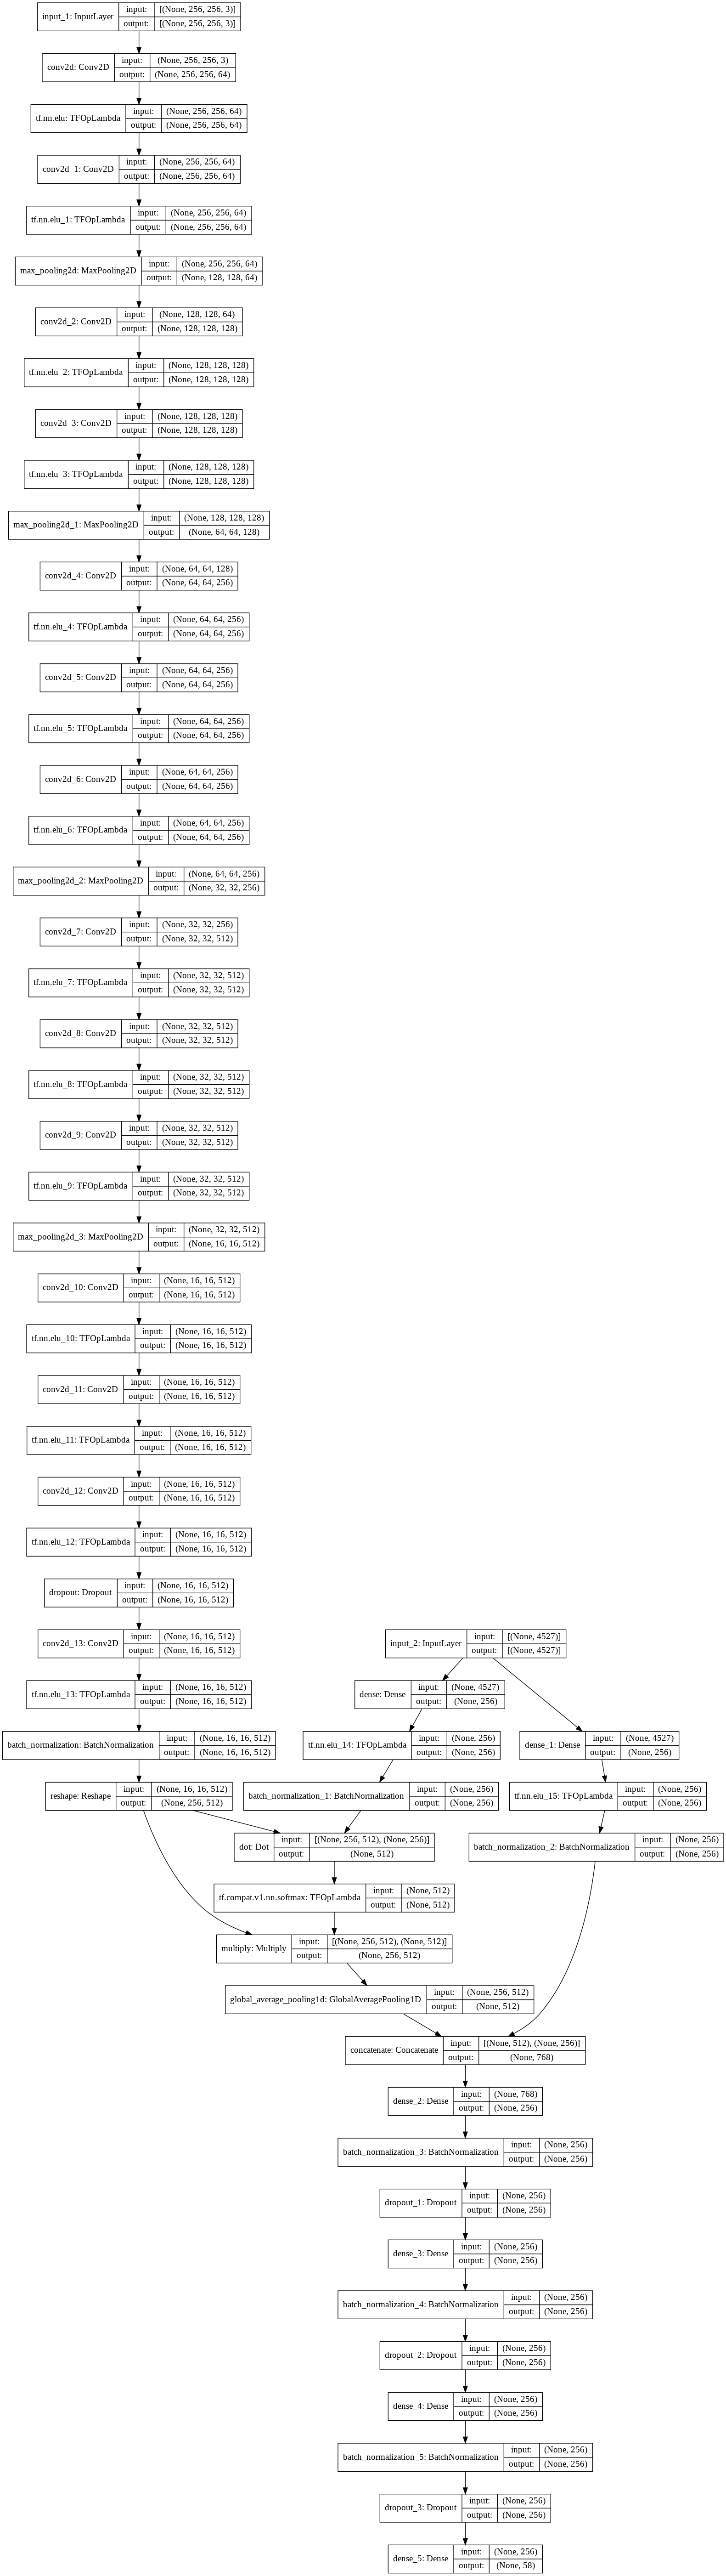

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training


In [ ]:
##########################################################################
# where to save model in model checkpoint
model_name = 'GAP_v2'

early = True
checkpoint = False
##########################################################################

filepath = os.path.join(cwd, model_name)

callback_list = []

# Early stopping
if(early):
  es = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0, 
    patience = 15,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True)
  callback_list.append(es)

# Model Checkpoint
if(checkpoint):
  cp = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq="epoch")
  callback_list.append(cp)

# At the end of each epoch predict an image of the training and one of the test 
# and saves it in the current folder. This is used to understand of the network is learning
#def PrintPrediction(epoch, logs):
#callback_list.append(print_callback)

In [ ]:
##########################################################################
#Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
optimizer = tf.keras.optimizers.Adamax(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# optimizer = tf.keras.optimizers.SGD()

# Validation metrics
metrics = ['accuracy', distance]
##########################################################################


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# model.layers[31].trainable = True
# model.layers[35].trainable = True

for layer in model.layers[0:freeze_until]:
    layer.trainable = True

In [ ]:
#############################################################
epochs = 5
#############################################################

model.fit(
  train_data_gen,
  epochs = epochs,
  steps_per_epoch = train_data_gen.__len__(),
  validation_data = validation_data_gen,
  validation_steps = validation_data_gen.__len__(),
  callbacks = callback_list,
  use_multiprocessing = True,
  workers = batch_size
)

In [ ]:
save_model(model, "/content/drive/MyDrive/Homework3/GAP_v2")

In [ ]:
def distance(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true-y_pred))/batch_size
    
model = tf.keras.models.load_model("/content/drive/MyDrive/GAP_v2", custom_objects={'distance':distance})

In [ ]:
for layer in model.layers[0:freeze_until]:
    layer.trainable = True